# Profitable Movies: 
## Budget, ROI, and Key Features

### Project Overview
This analysis of movie data, sourced from Kaggle, The Numbers, and IMDb, investigates the financial success of movies by analyzing the risk-reward relationship between production budget and profitability, adjusted to the yearly Consumer Price Index. This analysis leverages historical movie data to identify patterns and key features, such as genres, directors, and number of principals, that correlate with higher profitability. By applying statistical techniques like ANOVA and linear regression, the project uncovers which genres and budget categories lead to the most successful movies. Additionally, the project offers recommendations for future movie production, focusing on maximizing ROI based on these identified success factors.

### Business Problem
The movie industry operates in a highly competitive environment where production companies aim to maximize profitability while minimizing financial risk. However, predicting the financial success of a movie is challenging due to various factors like genre, budget, cast, and market trends. This project seeks to address this uncertainty by identifying the key features that drive higher returns on investment (ROI) for movies. The goal is to provide movie studios and producers with actionable insights to optimize their budgets and make informed decisions about which genres, directors, and budget levels are more likely to result in profitable outcomes. By analyzing historical data, the project can help studios focus their resources on the most promising projects, thereby improving financial performance in an unpredictable market.

### Data Understanding

The project uses movie data sourced from Kaggle, The Numbers, and IMDb and historical Consumer Price Index tables from the US Bureau of Labor Statistics. Key data fields include genres, adjusted production budgets, adjusted domestic and worldwide gross earnings, and directors’ information. The focus is on maximizing inflation-adjusted ROI to evaluate the financial success of movies, while accounting for risk as determined by production budget.

Key insights from the data include:

Genres like Horror, Family, and Comedy often deliver high ROI, especially for low-budget movies.
Directors with strong track records in specific genres tend to have higher ROI.
Data cleaning involved uniting disparate data sets, adjusting for inflation, handling missing values and normalizing multi-genre entries.
This data provided a strong foundation for further analysis using ANOVA tests and linear regression models to identify key success factors for movies.

#### Source Details

The Kaggle dataset has detailed financial and production information for movies, which is up-to-date and suitable for analysis. 

The Numbers is an online movie database service. The dataset from them is somewhat outdated but reasonably large. It incorporates few features but provides comprehensive budget and gross earnings data.

Consumer Price Index (CPI) Tables sourced from the US Bureau of Labor Statistics are used to adjust financial data for inflation, ensuring all monetary figures are standardized over time.

IMDb SQLite3 database is a rich and comprehensive source of movie features for analysis. However, it lacks financial metrics for evaluating movie success. It is structured as follows:

![ERD showing primary datasets "movie_basics" and "persons" with tables of relationships between movies and persons and some additional movie data tables](movie_data_erd.jpeg)

In [549]:
# Importing several standard modules in our Preparation and Analysis
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import matplotlib.ticker as mtick

In [550]:
#Connecting to our IMDB Sqlite database file
con = sqlite3.connect('Data/im.db')

In [551]:
#Use Pandas to quickly validate EDA information
pd.read_sql('''

SELECT *
FROM sqlite_master

''', con)

,type,name,tbl_name,rootpage,sql
0,table,movie_basics,movie_basics,2,"CREATE TABLE ""movie_basics"" (\n""movie_id"" TEXT..."
1,table,directors,directors,3,"CREATE TABLE ""directors"" (\n""movie_id"" TEXT,\n..."
2,table,known_for,known_for,4,"CREATE TABLE ""known_for"" (\n""person_id"" TEXT,\..."
3,table,movie_akas,movie_akas,5,"CREATE TABLE ""movie_akas"" (\n""movie_id"" TEXT,\..."
4,table,movie_ratings,movie_ratings,6,"CREATE TABLE ""movie_ratings"" (\n""movie_id"" TEX..."
5,table,persons,persons,7,"CREATE TABLE ""persons"" (\n""person_id"" TEXT,\n ..."
6,table,principals,principals,8,"CREATE TABLE ""principals"" (\n""movie_id"" TEXT,\..."
7,table,writers,writers,9,"CREATE TABLE ""writers"" (\n""movie_id"" TEXT,\n ..."


In [552]:
pd.read_sql('''

SELECT *
FROM movie_basics
LIMIT 15
        
''', con)

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"
5,tt0111414,A Thin Life,A Thin Life,2018,75.0,Comedy
6,tt0112502,Bigfoot,Bigfoot,2017,NaN,"Horror,Thriller"
7,tt0137204,Joe Finds Grace,Joe Finds Grace,2017,83.0,"Adventure,Animation,Comedy"
8,tt0139613,O Silêncio,O Silêncio,2012,NaN,"Documentary,History"
9,tt0144449,Nema aviona za Zagreb,Nema aviona za Zagreb,2012,82.0,Biography


### Data Preparation

In our project, data preparation was a key step to ensure accurate analysis.

We addressed missing values, removed duplicates, and ensured data consistency across all relevant fields.
We merged datasets (movies, directors, and others) based on movie_id and person_id to consolidate essential information like gross earnings, genres, and director details.
Handling Multi-Genres: We split multi-genre entries to analyze each genre's impact separately on metrics like ROI.
We normalized ROI by considering production budgets and gross earnings adjusted for inflation. We created new features like approval index and normalized budgets to improve insights.We filtered directors based on relevant criteria such as age and status (alive) for modern analysis.

In [553]:
# Reading in financial data csvs
tn_data = pd.read_csv('Data/tn.movie_budgets.csv')
kaggle_data = pd.read_csv('Data/movie_statistic_dataset.csv')
inflation_data  = pd.read_csv('Data/US_CPI.csv')

# Reading in IMDB movie basics
imdb_data = pd.read_sql('SELECT * FROM movie_basics', con)

# We investigated whether data from Box Office Mojo could fill in missing data from The Numbers, it did not turn out to be relevant.
bom_data = pd.read_csv('Data/bom.movie_gross.csv')

In [554]:
# Financial data in TN dataset was formatted as a string with $#,###,###
# converts monetary values in the dataset from strings to floats
tn_data['production_budget'] = tn_data['production_budget'].str.replace('$', '').str.replace(',', '').astype(float)
tn_data['domestic_gross'] = tn_data['domestic_gross'].str.replace('$', '').str.replace(',', '').astype(float)
tn_data['worldwide_gross'] = tn_data['worldwide_gross'].str.replace('$', '').str.replace(',', '').astype(float)


In [555]:
tn_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5782 non-null   int64  
 1   release_date       5782 non-null   object 
 2   movie              5782 non-null   object 
 3   production_budget  5782 non-null   float64
 4   domestic_gross     5782 non-null   float64
 5   worldwide_gross    5782 non-null   float64
dtypes: float64(3), int64(1), object(2)
memory usage: 271.2+ KB


In [556]:
# Filtering tn_data by production budget
tn_data = tn_data[tn_data['production_budget'] != 0]

In [557]:
# Merging tn_data with bom_data
tn_and_bom = tn_data.merge(bom_data, left_on='movie', right_on='title', how='left')

In [558]:
# Further filtering tn_and_bom based on domestic_gross values
tn_and_bom = tn_and_bom[(tn_and_bom['domestic_gross_x'] != 0) | (tn_and_bom['domestic_gross_y'].notnull())]

In [559]:
# the bom_data only contains information for 8 movies that are not already in the tn_data. 
# the analysis could stop looking further.
tn_and_bom[tn_and_bom['domestic_gross_x']==0 & (tn_and_bom['domestic_gross_y'].notnull())]

,id,release_date,movie,production_budget,domestic_gross_x,worldwide_gross,title,studio,domestic_gross_y,foreign_gross,year
2850,51,"Nov 14, 2014",Wolves,18000000.0,0.0,94953.0,Wolves,KE,12100.0,NaN,2014.0
3153,54,"Dec 6, 2013",Khumba,15000000.0,0.0,20898221.0,Khumba,MNE,1000.0,27200000,2013.0
4463,64,"Jun 6, 2014",Anna,4357373.0,0.0,1200000.0,Anna,VE,4300.0,NaN,2014.0
4768,69,"Sep 18, 1967",Point Blank,3000000.0,0.0,0.0,Point Blank,Magn.,708000.0,8500000,2011.0
4865,66,"Jan 19, 2016",Eden,2300000.0,0.0,0.0,Eden,BG,65500.0,NaN,2015.0
5330,31,"Dec 31, 2012",Trance,950000.0,0.0,0.0,Trance,FoxS,2300000.0,21900000,2013.0
5351,52,"Dec 31, 2012",Snitch,850000.0,0.0,0.0,Snitch,LG/S,42900000.0,NaN,2013.0
5415,16,"Mar 4, 2016",They Will Have to Kill Us First,600000.0,0.0,7943.0,They Will Have to Kill Us First,BBC,7500.0,NaN,2016.0


In [560]:
# filtering the dataset (tn_data) to remove any records where the domestic_gross is 0
tn_data = tn_data[tn_data['domestic_gross'] != 0]

In [561]:
# combining data from the two different sources (kaggle_data and tn_data) to form a comprehensive dataset, 
# which includes movie titles, production budgets, and gross earnings from both datasets.
money_data = kaggle_data.merge(tn_data, left_on='movie_title', right_on='movie', how='outer')

In [562]:
# Shows that aligning on title was largely successful.
money_data.head()

,movie_title,production_date,genres,runtime_minutes,director_name,director_professions,director_birthYear,director_deathYear,movie_averageRating,movie_numerOfVotes,approval_Index,Production budget $,Domestic gross $,Worldwide gross $,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,Avatar: The Way of Water,2022-12-09,"Action,Adventure,Fantasy",192.0,James Cameron,"writer,producer,director",1954,alive,7.8,277543.0,7.061101,460000000.0,667830256.0,2.265936e+09,NaN,NaN,NaN,NaN,NaN,NaN
1,Avengers: Endgame,2019-04-23,"Action,Adventure,Drama",181.0,-,-,-,-,8.4,1143642.0,8.489533,400000000.0,858373000.0,2.794732e+09,NaN,NaN,NaN,NaN,NaN,NaN
2,Pirates of the Caribbean: On Stranger Tides,2011-05-20,"Action,Adventure,Fantasy",137.0,Rob Marshall,"director,miscellaneous,producer",1960,alive,6.6,533763.0,6.272064,379000000.0,241071802.0,1.045714e+09,2.0,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,1.045664e+09
3,Avengers: Age of Ultron,2015-04-22,"Action,Adventure,Sci-Fi",141.0,Joss Whedon,"writer,producer,director",1964,alive,7.3,870573.0,7.214013,365000000.0,459005868.0,1.395317e+09,4.0,"May 1, 2015",Avengers: Age of Ultron,330600000.0,459005868.0,1.403014e+09
4,Avengers: Infinity War,2018-04-25,"Action,Adventure,Sci-Fi",149.0,-,-,-,-,8.4,1091968.0,8.460958,300000000.0,678815482.0,2.048360e+09,7.0,"Apr 27, 2018",Avengers: Infinity War,300000000.0,678815482.0,2.048134e+09


In [563]:
#Since the kaggle set was preserved (4527 entries) we can see that adding the TN dataset extended our data by over 1000 movies versus kaggle alone (to 5758 entries)
#But we also see that TN contributed 5434 entries and so there were also some 300 films in the Kaggle set that weren't in TN.
money_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5758 entries, 0 to 5757
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   movie_title           4527 non-null   object 
 1   production_date       4527 non-null   object 
 2   genres                4527 non-null   object 
 3   runtime_minutes       4527 non-null   float64
 4   director_name         4527 non-null   object 
 5   director_professions  4527 non-null   object 
 6   director_birthYear    4527 non-null   object 
 7   director_deathYear    4527 non-null   object 
 8   movie_averageRating   4527 non-null   float64
 9   movie_numerOfVotes    4527 non-null   float64
 10  approval_Index        4527 non-null   float64
 11  Production budget $   4527 non-null   float64
 12  Domestic gross $      4527 non-null   float64
 13  Worldwide gross $     4527 non-null   float64
 14  id                    5434 non-null   float64
 15  release_date         

In [564]:
# Handling missing values and filling in the gaps in our merged dataset (money_data)
# Any gaps in financial data from one dataset (Kaggle or The Numbers) are filled in by the other, retaining as much financial information as possible

money_data['Production budget $'].fillna(money_data['production_budget'], inplace=True)
money_data['Domestic gross $'].fillna(money_data['domestic_gross'], inplace=True)
money_data['Worldwide gross $'].fillna(money_data['worldwide_gross'], inplace=True)
money_data['movie_title'].fillna(money_data['movie'], inplace=True)
money_data['production_date'] = pd.to_datetime(money_data['production_date'], errors='coerce')#get dates into dt format
money_data['release_date'] = pd.to_datetime(money_data['release_date'], errors='coerce')#get dates into dt format
money_data['production_date'].fillna(money_data['release_date'], inplace=True)
money_data['year'] = money_data['production_date'].dt.year
print(money_data.head())

                                   movie_title production_date  \
0                     Avatar: The Way of Water      2022-12-09   
1                            Avengers: Endgame      2019-04-23   
2  Pirates of the Caribbean: On Stranger Tides      2011-05-20   
3                      Avengers: Age of Ultron      2015-04-22   
4                       Avengers: Infinity War      2018-04-25   

                     genres  runtime_minutes  director_name  \
0  Action,Adventure,Fantasy            192.0  James Cameron   
1    Action,Adventure,Drama            181.0              -   
2  Action,Adventure,Fantasy            137.0   Rob Marshall   
3   Action,Adventure,Sci-Fi            141.0    Joss Whedon   
4   Action,Adventure,Sci-Fi            149.0              -   

              director_professions director_birthYear director_deathYear  \
0         writer,producer,director               1954              alive   
1                                -                  -                  -

In [565]:
#Seeing that our combined data is complete for date and financial data. 
print(money_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5758 entries, 0 to 5757
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   movie_title           5758 non-null   object        
 1   production_date       4652 non-null   datetime64[ns]
 2   genres                4527 non-null   object        
 3   runtime_minutes       4527 non-null   float64       
 4   director_name         4527 non-null   object        
 5   director_professions  4527 non-null   object        
 6   director_birthYear    4527 non-null   object        
 7   director_deathYear    4527 non-null   object        
 8   movie_averageRating   4527 non-null   float64       
 9   movie_numerOfVotes    4527 non-null   float64       
 10  approval_Index        4527 non-null   float64       
 11  Production budget $   5758 non-null   float64       
 12  Domestic gross $      5758 non-null   float64       
 13  Worldwide gross $ 

#### Next step: Derived financial data - costs and gross adjusted to year

Understanding that dollar amounts do not directly correlate to actual value, this adjustment will ensure that all financial metrics are comparable across different time periods.

Preparing to adjust the costs and gross revenue data for inflation by using the Consumer Price Index (CPI) from the inflation_data DataFrame. The output of inflation_data.head() shows the structure of your CPI dataset.

In [566]:
inflation_data.head()

,Yearmon,CPI
0,01-01-1913,9.8
1,01-02-1913,9.8
2,01-03-1913,9.8
3,01-04-1913,9.8
4,01-05-1913,9.7


By selecting only December CPI values, we  ensure that inflation adjustments are based on a consistent point in each year, reducing variability within the year and allowing that the year of production/release is not usually the primary year of earnings, so the latest CPI attached to the production year is more accurate. 

In [567]:
#Convert Yearmon to datetime
inflation_data['Yearmon'] = pd.to_datetime(inflation_data['Yearmon'], errors='coerce')

# Filter the CPI values for December of each year.
# datetime incorrectly guessed 12 days in january per year rather than 1st day of 12 months, so "day" 12.
CPI_by_year = inflation_data[inflation_data['Yearmon'].dt.day == 12] 

#Create Year column
CPI_by_year['Year']=CPI_by_year['Yearmon'].dt.year

CPI_by_year.head()

C:\Users\Elif Surucu\AppData\Local\Temp\ipykernel_83464\974917147.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CPI_by_year['Year']=CPI_by_year['Yearmon'].dt.year


,Yearmon,CPI,Year
11,1913-01-12,10.0,1913
23,1914-01-12,10.1,1914
35,1915-01-12,10.3,1915
47,1916-01-12,11.6,1916
59,1917-01-12,13.7,1917


In [568]:
# Base year for inflation adjustment (choose the latest year in your dataset)
base_year = CPI_by_year['Year'].max()
base_cpi = CPI_by_year[CPI_by_year['Year'] == base_year]['CPI'].values[0]

# Merge inflation data with movie data
money_data = pd.merge(money_data, CPI_by_year, how='left', left_on='year', right_on='Year')

# Adjust values
money_data['adjusted_production_budget'] = (money_data['Production budget $'] * base_cpi) / money_data['CPI']
money_data['adjusted_domestic_gross'] = (money_data['Domestic gross $'] * base_cpi) / money_data['CPI']
money_data['adjusted_worldwide_gross'] = (money_data['Worldwide gross $'] * base_cpi) / money_data['CPI']

# Calculate Adjusted ROI
money_data['adjusted_ROI'] = (np.maximum(money_data['adjusted_worldwide_gross'], money_data['adjusted_domestic_gross']) - money_data['adjusted_production_budget']) / money_data['adjusted_production_budget']


# Drop unnecessary columns from the merge
money_data.drop(columns=['Year', 'CPI'], inplace=True)

# Preview adjusted data
print(money_data.head())


                                   movie_title production_date  \
0                     Avatar: The Way of Water      2022-12-09   
1                            Avengers: Endgame      2019-04-23   
2  Pirates of the Caribbean: On Stranger Tides      2011-05-20   
3                      Avengers: Age of Ultron      2015-04-22   
4                       Avengers: Infinity War      2018-04-25   

                     genres  runtime_minutes  director_name  \
0  Action,Adventure,Fantasy            192.0  James Cameron   
1    Action,Adventure,Drama            181.0              -   
2  Action,Adventure,Fantasy            137.0   Rob Marshall   
3   Action,Adventure,Sci-Fi            141.0    Joss Whedon   
4   Action,Adventure,Sci-Fi            149.0              -   

              director_professions director_birthYear director_deathYear  \
0         writer,producer,director               1954              alive   
1                                -                  -                  -

In [569]:
print(imdb_data.head())

    movie_id                    primary_title              original_title  \
0  tt0063540                        Sunghursh                   Sunghursh   
1  tt0066787  One Day Before the Rainy Season             Ashad Ka Ek Din   
2  tt0069049       The Other Side of the Wind  The Other Side of the Wind   
3  tt0069204                  Sabse Bada Sukh             Sabse Bada Sukh   
4  tt0100275         The Wandering Soap Opera       La Telenovela Errante   

   start_year  runtime_minutes                genres  
0        2013            175.0    Action,Crime,Drama  
1        2019            114.0       Biography,Drama  
2        2018            122.0                 Drama  
3        2018              NaN          Comedy,Drama  
4        2017             80.0  Comedy,Drama,Fantasy  


In [570]:
print(imdb_data.columns)

Index(['movie_id', 'primary_title', 'original_title', 'start_year',
       'runtime_minutes', 'genres'],
      dtype='object')


In [571]:
imdb_data['movie_title'] = imdb_data['primary_title'].str.strip()

# Merge the datasets using movie_title
combined_data = pd.merge(imdb_data, money_data, on='movie_title')

# Preview the merged dataset
print(combined_data.head())

    movie_id  primary_title original_title  start_year  runtime_minutes_x  \
0  tt0293429  Mortal Kombat  Mortal Kombat        2021                NaN   
1  tt0293429  Mortal Kombat  Mortal Kombat        2021                NaN   
2  tt0326592  The Overnight  The Overnight        2010               88.0   
3  tt3844362  The Overnight  The Overnight        2015               79.0   
4  tt0337692    On the Road    On the Road        2012              124.0   

                   genres_x    movie_title production_date  \
0  Action,Adventure,Fantasy  Mortal Kombat      2021-04-08   
1  Action,Adventure,Fantasy  Mortal Kombat      1995-08-18   
2                      None  The Overnight      2015-06-19   
3            Comedy,Mystery  The Overnight      2015-06-19   
4   Adventure,Drama,Romance    On the Road      2012-05-23   

                   genres_y  runtime_minutes_y  ...          movie  \
0  Action,Adventure,Fantasy              110.0  ...  Mortal Kombat   
1  Action,Adventure,Fant

In [572]:
# Drop unnecessary or duplicate columns
combined_data_cleaned = combined_data.drop(columns=['runtime_minutes_x', 'movie', 'production_date', 'genres_y'])

# Preview the cleaned dataset
print(combined_data_cleaned.head())

    movie_id  primary_title original_title  start_year  \
0  tt0293429  Mortal Kombat  Mortal Kombat        2021   
1  tt0293429  Mortal Kombat  Mortal Kombat        2021   
2  tt0326592  The Overnight  The Overnight        2010   
3  tt3844362  The Overnight  The Overnight        2015   
4  tt0337692    On the Road    On the Road        2012   

                   genres_x    movie_title  runtime_minutes_y  \
0  Action,Adventure,Fantasy  Mortal Kombat              110.0   
1  Action,Adventure,Fantasy  Mortal Kombat              101.0   
2                      None  The Overnight               79.0   
3            Comedy,Mystery  The Overnight               79.0   
4   Adventure,Drama,Romance    On the Road              124.0   

        director_name      director_professions director_birthYear  ...  \
0       Simon McQuoid         director,producer                 \N  ...   
1  Paul W.S. Anderson  writer,director,producer               1965  ...   
2       Patrick Brice     director,

In [573]:
combined_data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4182 entries, 0 to 4181
Data columns (total 28 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   movie_id                    4182 non-null   object        
 1   primary_title               4182 non-null   object        
 2   original_title              4181 non-null   object        
 3   start_year                  4182 non-null   int64         
 4   genres_x                    4109 non-null   object        
 5   movie_title                 4182 non-null   object        
 6   runtime_minutes_y           3771 non-null   float64       
 7   director_name               3771 non-null   object        
 8   director_professions        3771 non-null   object        
 9   director_birthYear          3771 non-null   object        
 10  director_deathYear          3771 non-null   object        
 11  movie_averageRating         3771 non-null   float64     

In [574]:
imdb_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146144 entries, 0 to 146143
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   movie_id         146144 non-null  object 
 1   primary_title    146144 non-null  object 
 2   original_title   146123 non-null  object 
 3   start_year       146144 non-null  int64  
 4   runtime_minutes  114405 non-null  float64
 5   genres           140736 non-null  object 
 6   movie_title      146144 non-null  object 
dtypes: float64(1), int64(1), object(5)
memory usage: 7.8+ MB


In [575]:
df_clean_movies = combined_data_cleaned[['movie_id','movie_title','genres_x','year','director_name','director_birthYear','director_deathYear',
                                            'adjusted_production_budget','adjusted_domestic_gross','adjusted_worldwide_gross','adjusted_ROI',
                                            'movie_averageRating','movie_numerOfVotes','approval_Index']]
df_clean_movies.head()

,movie_id,movie_title,genres_x,year,director_name,director_birthYear,director_deathYear,adjusted_production_budget,adjusted_domestic_gross,adjusted_worldwide_gross,adjusted_ROI,movie_averageRating,movie_numerOfVotes,approval_Index
0,tt0293429,Mortal Kombat,"Action,Adventure,Fantasy",2021.0,Simon McQuoid,\N,alive,NaN,NaN,NaN,NaN,6.0,176605.0,5.201632
1,tt0293429,Mortal Kombat,"Action,Adventure,Fantasy",1995.0,Paul W.S. Anderson,1965,alive,3.393798e+07,1.195181e+08,2.072478e+08,5.106661,5.8,119670.0,4.857774
2,tt0326592,The Overnight,None,2015.0,Patrick Brice,1983,alive,2.202507e+05,1.222180e+06,1.284057e+06,4.829980,6.1,17175.0,4.244593
3,tt3844362,The Overnight,"Comedy,Mystery",2015.0,Patrick Brice,1983,alive,2.202507e+05,1.222180e+06,1.284057e+06,4.829980,6.1,17175.0,4.244593
4,tt0337692,On the Road,"Adventure,Drama,Romance",2012.0,Walter Salles,1956,alive,2.836159e+07,8.177532e+05,1.056560e+07,-0.627468,6.0,42341.0,4.571170


In [576]:
df_clean_movies['director_birthYear'] = pd.to_numeric(df_clean_movies['director_birthYear'], errors='coerce')
available_directors = df_clean_movies[
    (df_clean_movies['director_birthYear'] > 1952) |
    (df_clean_movies['director_birthYear'].isna()) & 
    (df_clean_movies['director_deathYear']=='alive')
]
director_roi = available_directors.groupby('director_name')['adjusted_ROI'].mean().sort_values(ascending=False).reset_index()

print(director_roi.head())

     director_name  adjusted_ROI
0  Aneesh Chaganty     84.950053
1  Nathaniel Davis     68.609409
2     Tod Williams     58.170677
3   Bradley Parker     41.411721
4    Nitesh Tiwari     31.120996


C:\Users\Elif Surucu\AppData\Local\Temp\ipykernel_83464\94421737.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_movies['director_birthYear'] = pd.to_numeric(df_clean_movies['director_birthYear'], errors='coerce')


In [577]:
print(director_roi.head(50))

         director_name  adjusted_ROI
0      Aneesh Chaganty     84.950053
1      Nathaniel Davis     68.609409
2         Tod Williams     58.170677
3       Bradley Parker     41.411721
4        Nitesh Tiwari     31.120996
5        Barry Jenkins     28.451563
6       William Lustig     27.571429
7    David F. Sandberg     23.777532
8   William Brent Bell     22.735758
9         Jordan Peele     21.215722
10      Stephen Daldry     20.850594
11         Jeff Wadlow     20.568114
12    John R. Leonetti     19.736494
13        Stiles White     19.660126
14    Oyefunke Fayoyin     18.735563
15      Michael Madsen     18.735563
16      John Krasinski     18.698628
17       Chuck Russell     18.534452
18        Daniel Stamm     18.496472
19     Takashi Shimizu     17.728111
20      James DeMonaco     17.222144
21        Adam Robitel     16.288277
22       Alex Kendrick     15.708095
23         Corin Hardy     15.517802
24       Stephen Susco     15.434588
25    Scott Derrickson     15.379035
2

In [578]:
available_directors['genres_x'].fillna('Unknown', inplace=True)

director_stats = available_directors.groupby('director_name').agg({
    'genres_x': lambda x: ', '.join(set(x)),  # Get unique genres and join them as a string
    'adjusted_production_budget': 'mean'  # Calculate the average adjusted production budget
}).reset_index()
director_full_stats = pd.merge(director_roi, director_stats, on='director_name')

C:\Users\Elif Surucu\AppData\Local\Temp\ipykernel_83464\3379184613.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  available_directors['genres_x'].fillna('Unknown', inplace=True)


In [579]:
director_full_stats['budget_category'] = pd.cut(director_full_stats['adjusted_production_budget'], 
                                                bins=[0, 5e6, 2e7, np.inf], #based on google research
                                                labels=['Low Budget', 'Medium Budget', 'High Budget'])
budget_analysis = director_full_stats.groupby('budget_category')['adjusted_ROI'].mean().reset_index()
budget_analysis

,budget_category,adjusted_ROI
0,Low Budget,3.658724
1,Medium Budget,3.100126
2,High Budget,1.795999


In [580]:
movie_counts = available_directors.groupby('director_name').size().reset_index(name='movie_count')

director_full_stats = pd.merge(director_full_stats, movie_counts, on='director_name')

target_genres = ['Horror', 'Musical', 'Drama']
filtered_data = director_full_stats[
    (director_full_stats['genres_x'].str.contains('|'.join(target_genres))) &
    (director_full_stats['budget_category'] != 'High Budget')
]


top_directors = filtered_data[['director_name', 'adjusted_ROI', 'genres_x', 'adjusted_production_budget', 'budget_category', 'movie_count']].sort_values(by='adjusted_ROI', ascending=False)

In [581]:
df_cleaned_exploded = df_clean_movies.copy()
df_cleaned_exploded['genres_x'] = df_cleaned_exploded['genres_x'].str.split(',')
df_cleaned_exploded = df_cleaned_exploded.explode('genres_x')
df_cleaned_exploded['genres_x'].replace({None:'Unknown','None':'Unknown'},inplace=True)

In [582]:
# Group by genres and calculate the mean adjusted ROI for each genre
avg_roi_by_genre = df_cleaned_exploded.groupby('genres_x')['adjusted_ROI'].mean().reset_index()

print(avg_roi_by_genre)

       genres_x  adjusted_ROI
0        Action      2.751306
1     Adventure      2.723109
2     Animation      6.550155
3     Biography      5.408469
4        Comedy      3.478032
5         Crime      1.627109
6   Documentary      7.096304
7         Drama      3.943486
8        Family      8.183093
9       Fantasy      6.716002
10      History      7.406279
11       Horror     10.625969
12        Music      4.976964
13      Musical     13.051526
14      Mystery      6.318434
15         News      0.431002
16      Romance      4.709546
17       Sci-Fi      2.492529
18        Sport      1.756669
19     Thriller      6.229830
20      Unknown      2.808354
21          War      4.720302
22      Western      0.547716


In [583]:
genres = df_cleaned_exploded['genres_x'].unique()


roi_data = [df_cleaned_exploded[df_cleaned_exploded['genres_x'] == genre]['adjusted_ROI'].dropna() for genre in genres]
roi_data = [data for data in roi_data if len(data) > 0]  # Keep only non-empty genre groups

In [584]:
#I wonder if number of principals has any bearing on ROI
principals_count = pd.read_sql('''
                        SELECT movie_id, COUNT(person_id) AS principal_count
                        FROM principals
                        GROUP BY movie_id
                        ''',con)
principals_count.head()

,movie_id,principal_count
0,tt0063540,10
1,tt0066787,7
2,tt0069049,10
3,tt0069204,10
4,tt0100275,10


In [585]:
#Adding number of principals to our dataframe
df_clean_movies = df_clean_movies.merge(principals_count, on='movie_id',how='left')
df_clean_movies['principal_count'] = df_clean_movies['principal_count'].fillna(0)

## Data Analysis

### Overview:
We begin by exploring and visualizing the adjusted financial metrics to gain initial insights into movie performance. From there, we perform a more in-depth analysis by examining key features such as budget categories, genres, director performance, and principal counts to better understand their influence on ROI and profitability, leading to several actionable recommendations to maximize expected ROI while controlling risk. 

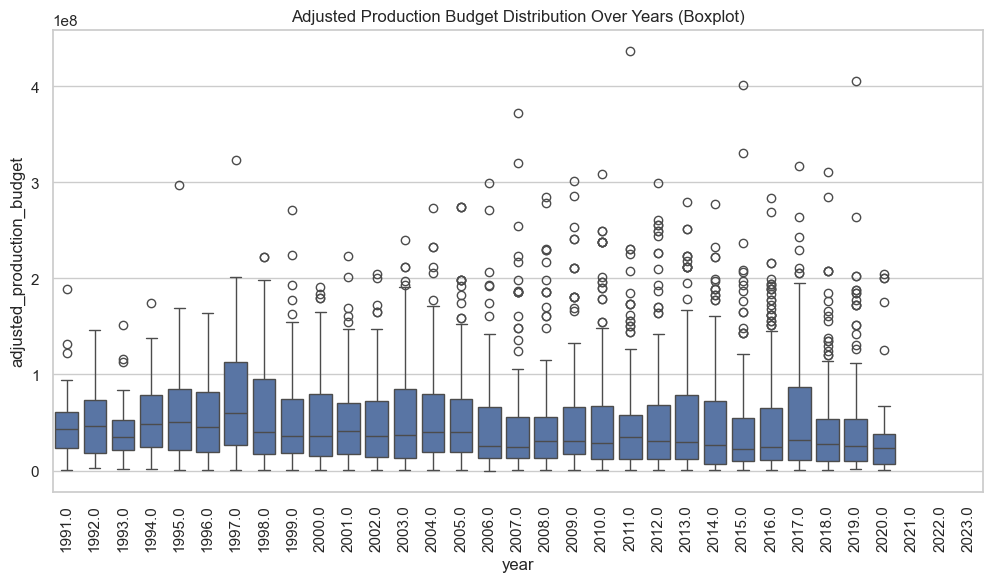

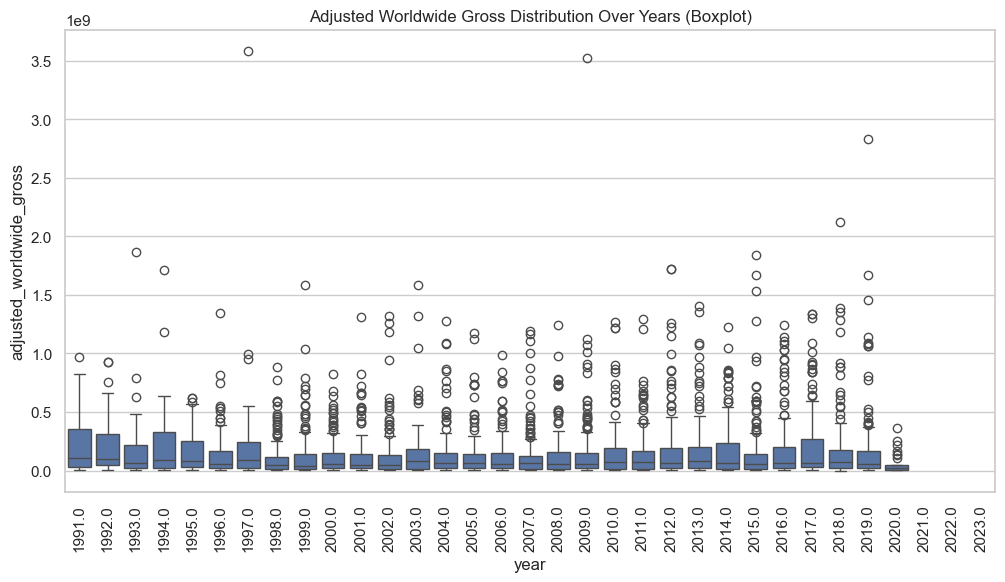

In [586]:
#Visualizing recent budget and gross earnings (since 1990)

filtered_data = money_data[money_data['year'] > 1990]

# Distribution by years with boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(x='year', y='adjusted_production_budget', data=filtered_data)
plt.xticks(rotation=90)  # X eksenindeki yılları net görmek için döndürme
plt.title('Adjusted Production Budget Distribution Over Years (Boxplot)')
plt.show()

# Likewise for Worldwide Gross
plt.figure(figsize=(12, 6))
sns.boxplot(x='year', y='adjusted_worldwide_gross', data=filtered_data)
plt.xticks(rotation=90)
plt.title('Adjusted Worldwide Gross Distribution Over Years (Boxplot)')
plt.show()

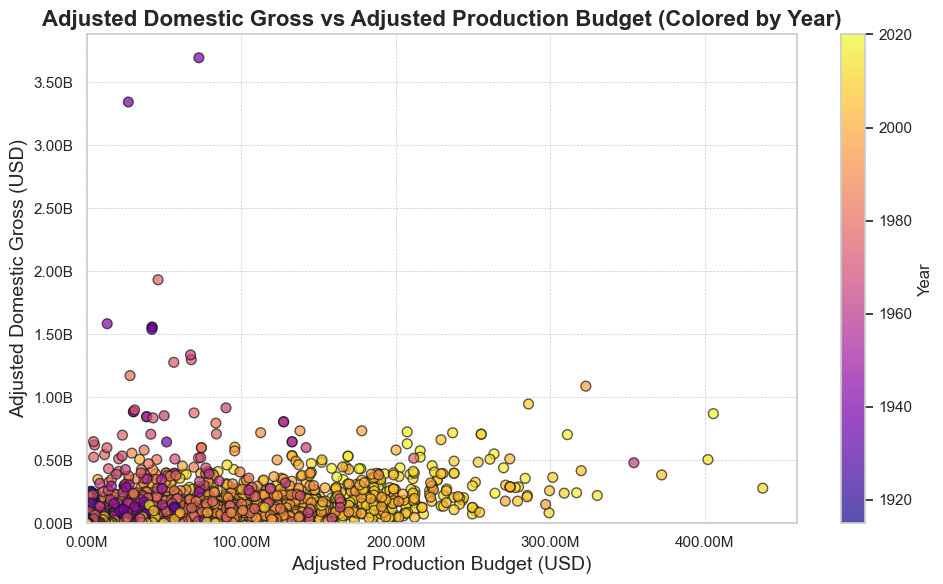

In [587]:

# Set plot style
sns.set_theme(style="whitegrid")

# Scatter plot for Adjusted Domestic Gross vs Adjusted Production Budget
plt.figure(figsize=(10, 6))

# Define the scatter plot with better visual parameters
scatter = plt.scatter(money_data['adjusted_production_budget'],
                      money_data['adjusted_domestic_gross'],
                      c=money_data['year'], cmap='plasma', s=50, alpha=0.7, edgecolor='k')

# Add a color bar to indicate the years
cbar = plt.colorbar(scatter)
cbar.set_label('Year')

# Set titles and labels
plt.title('Adjusted Domestic Gross vs Adjusted Production Budget (Colored by Year)', fontsize=16, fontweight='bold')
plt.xlabel('Adjusted Production Budget (USD)', fontsize=14)
plt.ylabel('Adjusted Domestic Gross (USD)', fontsize=14)

plt.xlim(left=0)
plt.ylim(bottom=0)

plt.grid(True, which='both', linestyle='--', linewidth=0.5)
#Remove scientific notation

plt.gca().xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x * 1e-6:.2f}M'))
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda y, _: f'{y * 1e-9:.2f}B'))
plt.tight_layout()
plt.show()

These exploratory visualizations of the data emphasize the significant variance in gross earnings and, consequently, in return on investment (ROI). The color scale indicates that more recent films (yellow and light orange) tend to have higher production budgets than older films (purple), reflecting expansion and capitalization of the industry. 

Intercept: 7939072.911640227
Slope: 3.2270486961083593
R-squared: 0.29326604256880884


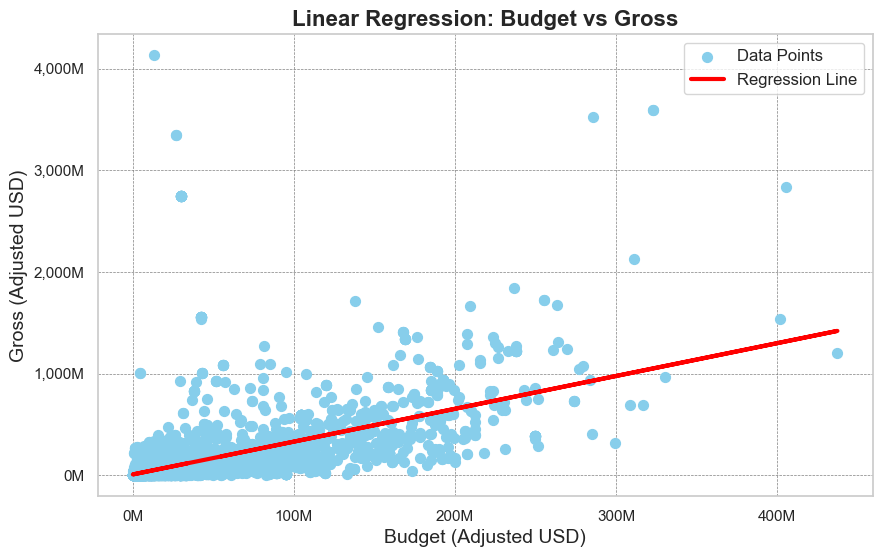

In [588]:
# Select the independent (X) and dependent (y) variables
X = df_clean_movies['adjusted_production_budget'].dropna().values.reshape(-1, 1)
y = np.maximum(df_clean_movies['adjusted_worldwide_gross'], df_clean_movies['adjusted_domestic_gross']).dropna().values

# Fit the linear regression model
model = LinearRegression()
model.fit(X, y)

# Print the coefficients
print(f"Intercept: {model.intercept_}")
print(f"Slope: {model.coef_[0]}")

# Predict values using the model
y_pred = model.predict(X)
r2 = r2_score(y, y_pred)
print(f"R-squared: {r2}")

# Plot the regression line and data points
plt.figure(figsize=(10, 6))
plt.scatter(X, y, color='skyblue', s=50, label='Data Points')
plt.plot(X, y_pred, color='red', linewidth=3, label='Regression Line')
plt.xlabel('Budget (Adjusted USD)', fontsize=14)
plt.ylabel('Gross (Adjusted USD)', fontsize=14)
plt.title('Linear Regression: Budget vs Gross', fontsize=16, fontweight='bold')

# Remove scientific notation from axes
plt.gca().xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: '{:,.0f}M'.format(x / 1e6)))
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda y, _: '{:,.0f}M'.format(y / 1e6)))

plt.legend(loc='upper right', fontsize=12)
plt.grid(color='gray', linestyle='--', linewidth=0.5)
plt.show()

C:\Users\Elif Surucu\AppData\Local\Temp\ipykernel_83464\597104307.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='budget_category', y='adjusted_ROI', data=budget_analysis, palette='coolwarm', linewidth=2.5, edgecolor='black')


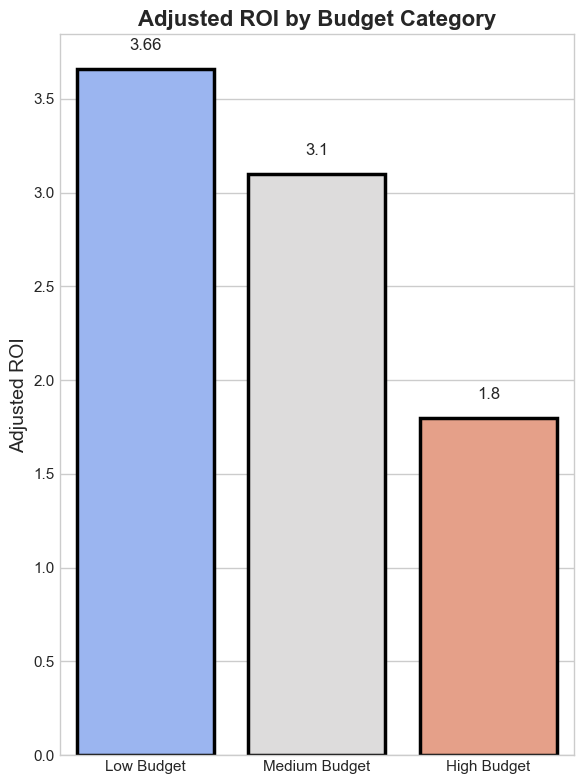

In [611]:
budget_analysis = pd.DataFrame({
    'budget_category': ['Low Budget', 'Medium Budget', 'High Budget'],
    'adjusted_ROI': [3.66, 3.1, 1.8]
})

# Create the bar plot
plt.figure(figsize=(6, 8))
sns.barplot(x='budget_category', y='adjusted_ROI', data=budget_analysis, palette='coolwarm', linewidth=2.5, edgecolor='black')

# Add labels and title
plt.title('Adjusted ROI by Budget Category', fontsize=16, weight='bold')
plt.ylabel('Adjusted ROI', fontsize=14)
plt.xlabel('', fontsize=14)

# Add data labels on top of bars
for i in range(len(budget_analysis)):
    plt.text(i, budget_analysis['adjusted_ROI'][i] + 0.1, round(budget_analysis['adjusted_ROI'][i], 2),
             ha='center', fontsize=12)

# Final adjustments to layout and display
plt.tight_layout()
plt.show()

In [589]:
budget_analysis

,budget_category,adjusted_ROI
0,Low Budget,3.658724
1,Medium Budget,3.100126
2,High Budget,1.795999


Given the noisy data, the first logical question is: "What is the relationship between budget and gross revenue?" From the model, we observe that for each budget dollar spent, there is an expected gross earning of $3.19, with budget explaining 30% of the variance. However, when analyzing budget categories, we notice that high-budget films have a diminished ROI compared to low-to-medium budget films. Therefore, increasing the budget within reasonable limits would be an effective strategy for maximizing revenue, but managing risk exposure is key - it's more worthwhile to be able to make 2 mid-budget films than to overreach for a higher budget film.

Approval Index: Intercept = -5.030036371720843, Coeff = 2.0346526254831017, R-squared = 0.026539190950570446
Movie Average Rating: Intercept = -19.485044232923155, Coeff = 3.7741666484445187, R-squared = 0.04105811552731675


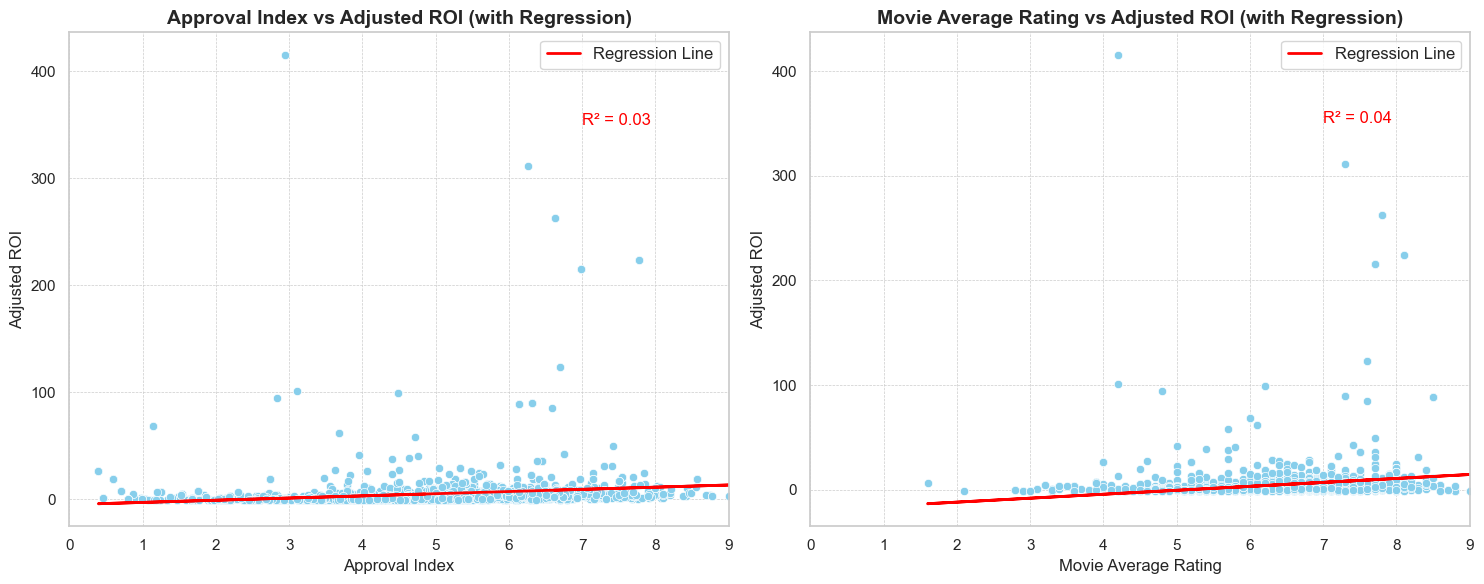

In [590]:
df_filtered = df_clean_movies[['approval_Index', 'adjusted_ROI']].dropna()
X_approval = df_filtered['approval_Index'].values.reshape(-1, 1)
y = df_filtered['adjusted_ROI'].values

# Linear regression model for Approval Index
model_approval = LinearRegression()
model_approval.fit(X_approval, y)
r2_approval = model_approval.score(X_approval, y)

# Filter data for Movie Average Rating vs Adjusted ROI
df_filtered_rating = df_clean_movies[['movie_averageRating', 'adjusted_ROI']].dropna()
X_rating = df_filtered_rating['movie_averageRating'].values.reshape(-1, 1)
y_rating = df_filtered_rating['adjusted_ROI'].values

# Linear regression model for Movie Average Rating
model_rating = LinearRegression()
model_rating.fit(X_rating, y_rating)
r2_rating = model_rating.score(X_rating, y_rating)

# Print intercepts, coefficients, and R-squared values
print(f"Approval Index: Intercept = {model_approval.intercept_}, Coeff = {model_approval.coef_[0]}, R-squared = {r2_approval}")
print(f"Movie Average Rating: Intercept = {model_rating.intercept_}, Coeff = {model_rating.coef_[0]}, R-squared = {r2_rating}")

# Visualize the regression lines
plt.figure(figsize=(15, 6))

# Define the common x-axis limits for both plots
x_limits = (0, 9)  # Adjust these limits according to your data

# Subplot for Approval Index vs Adjusted ROI
plt.subplot(1, 2, 1)
sns.scatterplot(data=df_clean_movies, x='approval_Index', y='adjusted_ROI', color='skyblue')
plt.plot(X_approval, model_approval.predict(X_approval), color='red', label='Regression Line', linewidth=2)
plt.title('Approval Index vs Adjusted ROI (with Regression)', fontsize=14, weight='bold')
plt.xlabel('Approval Index', fontsize=12)
plt.ylabel('Adjusted ROI', fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.text(7, 350, f'R² = {r2_approval:.2f}', fontsize=12, color='red')
plt.xlim(x_limits)  # Set the same x-axis limits for consistency
plt.legend(loc='upper right', fontsize=12)

# Subplot for Movie Average Rating vs Adjusted ROI
plt.subplot(1, 2, 2)
sns.scatterplot(data=df_clean_movies, x='movie_averageRating', y='adjusted_ROI', color='skyblue')
plt.plot(X_rating, model_rating.predict(X_rating), color='red', label='Regression Line', linewidth=2)
plt.title('Movie Average Rating vs Adjusted ROI (with Regression)', fontsize=14, weight='bold')
plt.xlabel('Movie Average Rating', fontsize=12)
plt.ylabel('Adjusted ROI', fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.text(7, 350, f'R² = {r2_rating:.2f}', fontsize=12, color='red')
plt.xlim(x_limits)  # Set the same x-axis limits for consistency
plt.legend(loc='upper right', fontsize=12)

# Tight layout to avoid overlapping of subplots
plt.tight_layout()
plt.show()

Both the approval index and movie average rating have very weak positive correlations with ROI, with R-squared values of 2.6% for Approval and 4% for Ratings. 
The relationships are small but present, as indicated by the positive slopes of both regression lines. However, the high dispersion of the data (especially in the ROI outliers) suggests other factors may have a stronger influence on ROI. In general it is recommended to ignore ratings as an avenue to ROI. 

In [591]:
# Run the ANOVA test on genre 
genre_anova_result = stats.f_oneway(*roi_data)

# Display the results
print(f'ANOVA F-statistic: {genre_anova_result.statistic}, p-value: {genre_anova_result.pvalue}')

ANOVA F-statistic: 5.387516543074256, p-value: 4.418108587755657e-15



Interpretation:
Since the p-value is less than 0.05, we can reject the null hypothesis. This means that there are significant differences in the average ROI among the genres and some genres likely have better ROI compared to others.

A Tukey HSD test can help us with post-hoc analysis of these differences.

In [592]:
df_cleaned_exploded = df_cleaned_exploded.dropna(subset=['adjusted_ROI', 'genres_x'])

In [593]:
genre_tk_hsd = pairwise_tukeyhsd(df_cleaned_exploded['adjusted_ROI'], df_cleaned_exploded['genres_x'], alpha=.05)


c:\Users\Elif Surucu\anaconda3\envs\Cohort_Env\lib\site-packages\scipy\integrate\_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


<Figure size 1200x800 with 0 Axes>

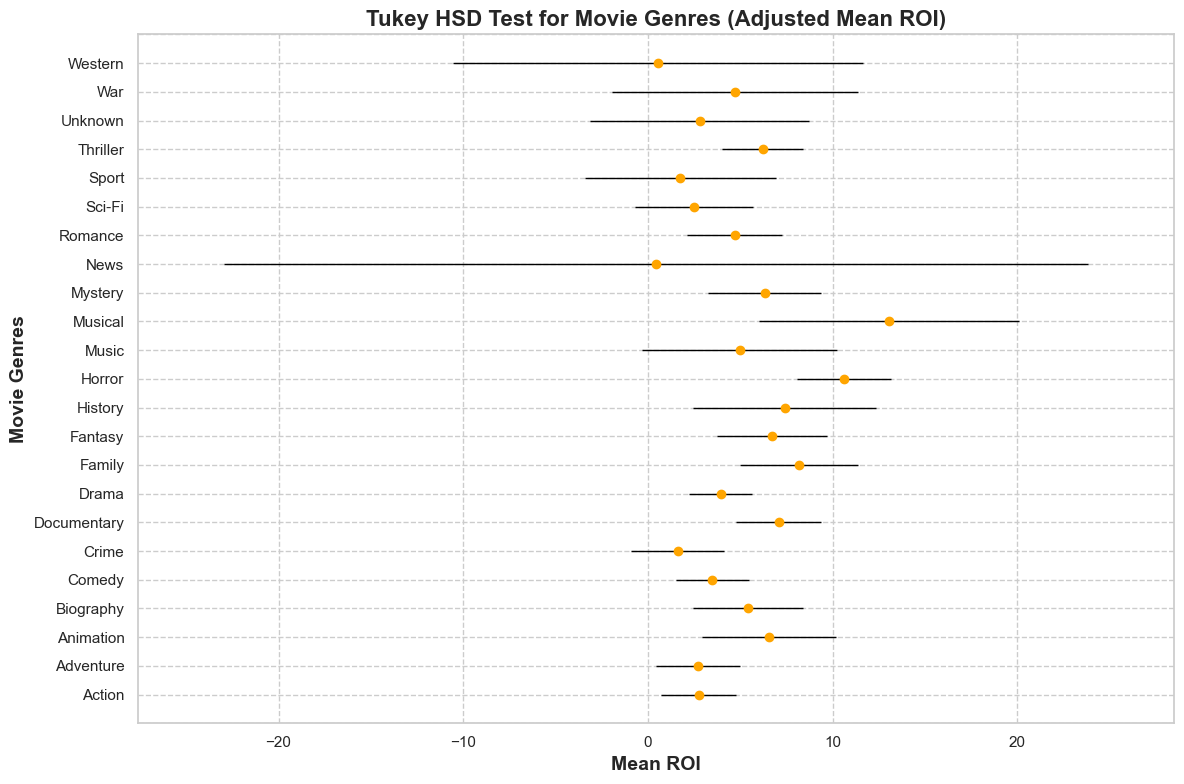

In [594]:
genre_tk_hsd = pairwise_tukeyhsd(df_cleaned_exploded['adjusted_ROI'], df_cleaned_exploded['genres_x'], alpha=0.05)


plt.figure(figsize=(12, 8))

genre_tk_hsd.plot_simultaneous(figsize=(12, 8))


lines = plt.gca().lines
for line in lines:
    line.set_color('orange')  
    line.set_linewidth(2)  


points = plt.gca().collections[0]
points.set_edgecolor('black')  
points.set_linewidth(1)  


plt.title('Tukey HSD Test for Movie Genres (Adjusted Mean ROI)', fontsize=16, weight='bold')
plt.xlabel('Mean ROI', fontsize=14, weight='bold')  # Adjusted x label
plt.ylabel('Movie Genres', fontsize=14, weight='bold')

plt.grid(True, linestyle='--', linewidth=1)
plt.tight_layout()


plt.show()

This visualization clearly shows the confidence intervals for ROI differences between various movie genres. It helps pinpoint which genres tend to perform better or worse in terms of ROI. For example, our data shows a high degree of confidence in the mean ROI for horror films. However, some high-performing genres, like musicals, are not as well-represented in the data, so they exhibit wider confidence intervals. Even so, musicals still rank among the genres with the strongest average ROIs and may still also be a good option. Drama represents a third tier with small confidence interval and strong mean ROI as another emminently reasonable choice depending on other production factors.

From the graph, we observe overall that each budget dollar generates an expected gross earning of $3.19, with budget explaining approximately 30% of the variance. However, when analyzing budget categories, we note a diminished ROI for high-budget films compared to low-to-medium budget films. Therefore, increasing the available budget within reasonable limits appears to be a more effective strategy.

In [595]:
# ANOVA test setup for count of principals in a movie
principal_count_roi = [df_clean_movies[df_clean_movies['principal_count'] == count]['adjusted_ROI'].dropna() for count in list(range(1,11))]

# Run the ANOVA test
pcr_anova_result = stats.f_oneway(*principal_count_roi)

# Display the results
print(f'ANOVA F-statistic: {pcr_anova_result.statistic}, p-value: {pcr_anova_result.pvalue}')

ANOVA F-statistic: 3.78767709559879, p-value: 9.059461072836496e-05


Results are significant for p<0.5 so we follow up with a tukey test to determine which numbers of principals perform well.

<Figure size 1200x800 with 0 Axes>

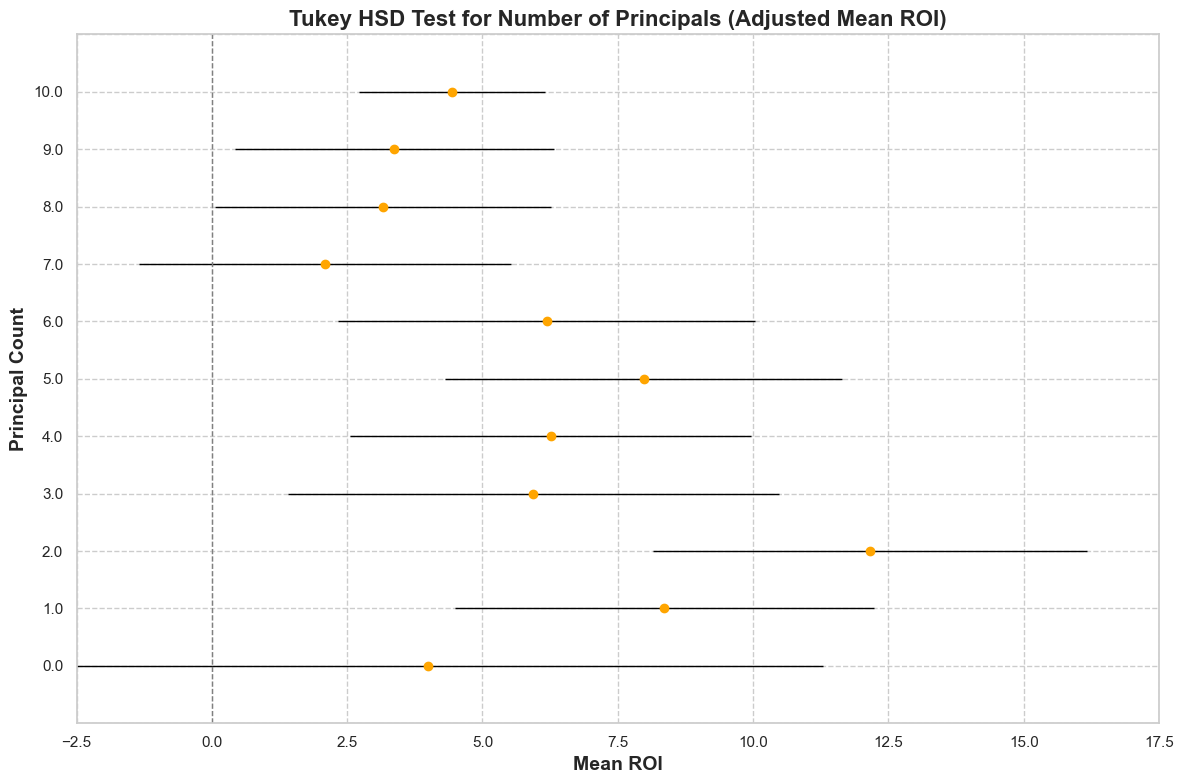

In [596]:
df_clean_filtered = df_clean_movies.replace([np.inf, -np.inf], np.nan).dropna(subset=['adjusted_ROI', 'principal_count'])

# Perform the Tukey HSD test
pcr_tk_hsd = pairwise_tukeyhsd(df_clean_filtered['adjusted_ROI'], df_clean_filtered['principal_count'], alpha=0.05)


plt.figure(figsize=(12, 8))

# Plot the Tukey HSD results
pcr_tk_hsd.plot_simultaneous(figsize=(12, 8))


lines = plt.gca().lines
for line in lines:
    line.set_color('orange') 
    line.set_linewidth(2)     


points = plt.gca().collections[0]
points.set_edgecolor('black')  
points.set_linewidth(1)        


plt.axvline(0, color='grey', linestyle='--', linewidth=1)

plt.xlim(-2.5, 17.5)
plt.title('Tukey HSD Test for Number of Principals (Adjusted Mean ROI)', fontsize=16, weight='bold')
plt.xlabel('Mean ROI', fontsize=14, weight='bold')
plt.ylabel('Principal Count', fontsize=14, weight='bold')


plt.grid(True, linestyle='--', linewidth=1)


plt.tight_layout()


plt.show()

This visualization helps identify which specific groups of principal counts perform better or worse in terms of ROI. The confidence intervals allow us to assess which principal counts significantly differ from each other in terms of financial performance. Specifically we see that 2 principals has signficiantly higher mean ROI than 7-10 principlas with 95% confidence, and has the highest mean ROI overall, so it seems likely that a "dynamic duo" can boost a film's appeal, while a large principal cast is more risky. 

In [597]:
top_directors.head(20)

,director_name,adjusted_ROI,genres_x,adjusted_production_budget,budget_category,movie_count
0,Aneesh Chaganty,84.950053,"Drama,Mystery,Thriller",9.123687e+05,Low Budget,1
1,Nathaniel Davis,68.609409,Horror,6.600000e+04,Low Budget,2
2,Tod Williams,58.170677,Horror,3.565223e+06,Low Budget,1
3,Bradley Parker,41.411721,"Horror,Mystery,Thriller",1.134464e+06,Low Budget,1
4,Nitesh Tiwari,31.120996,"Action,Biography,Drama, Action",1.024928e+07,Medium Budget,2
5,Barry Jenkins,28.451563,"Drama, Drama,Romance, Horror",5.226001e+06,Medium Budget,3
6,William Lustig,27.571429,"Action,Horror,Thriller, Horror,Thriller",1.056384e+06,Low Budget,2
7,David F. Sandberg,23.777532,"Drama, Horror,Mystery,Thriller, Drama,Horror,M...",1.842547e+07,Medium Budget,7
8,William Brent Bell,22.735758,"Horror,Mystery,Thriller, Drama,Horror,Thriller...",1.170539e+07,Medium Budget,5
9,Jordan Peele,21.215722,"Drama, Horror,Mystery,Thriller, Comedy",1.652503e+07,Medium Budget,4


C:\Users\Elif Surucu\AppData\Local\Temp\ipykernel_83464\547589206.py:12: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  bar_plot = sns.barplot(x="movie_count", y="adjusted_ROI", data=top_directors_sorted, palette="Blues_d", ci=None)
C:\Users\Elif Surucu\AppData\Local\Temp\ipykernel_83464\547589206.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x="movie_count", y="adjusted_ROI", data=top_directors_sorted, palette="Blues_d", ci=None)


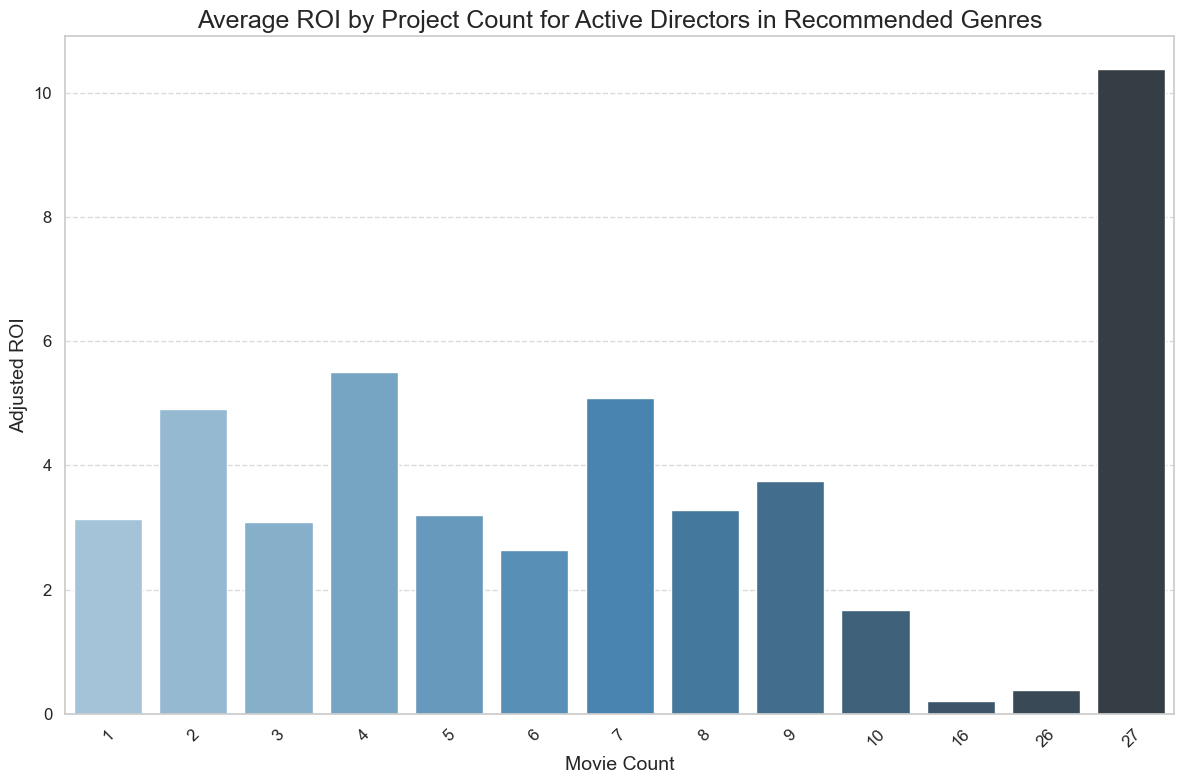

In [598]:
top_directors_clean = top_directors.dropna(subset=['movie_count', 'adjusted_ROI'])
top_directors_clean = top_directors_clean[np.isfinite(top_directors_clean['movie_count'])]
top_directors_clean = top_directors_clean[np.isfinite(top_directors_clean['adjusted_ROI'])]


top_directors_sorted = top_directors_clean.sort_values(by='movie_count')


plt.figure(figsize=(12, 8))


bar_plot = sns.barplot(x="movie_count", y="adjusted_ROI", data=top_directors_sorted, palette="Blues_d", ci=None)


plt.title("Average ROI by Project Count for Active Directors in Recommended Genres", fontsize=18)
plt.xlabel("Movie Count", fontsize=14)
plt.ylabel("Adjusted ROI", fontsize=14)

plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

plt.grid(axis='y', linestyle='--', alpha=0.7)


plt.tight_layout()
plt.show()

Here we have a list of our top 25 available and affordable high-performing directors (measured by mean ROI) who work in Horror and/or Drama, with helpful annotations on budget category and the number of movies they directed that we have data for. Given the small sample sizes, statistical comparisons like ANOVA or Tukey's test may not provide significant insights. However, this list can serve as a reliable starting point for determining which directors to approach. With confidence in their track record, directors like Jordan Peele, Jeff Wadlow, or Michael Madsen would be ideal partners for any project. 

## Conclusion

- While larger budgets can lead to higher gross earnings, our analysis shows that ROI diminishes as budgets increase. High-budget films tend to offer lower returns compared to low- to medium-budget productions. It's essential to strike a balance—allocate enough resources to ensure quality, but avoid overspending, as the additional costs may not be justified by the returns.

- High ratings, including approval indexes and average ratings, have minimal impact on ROI. Focusing too much on achieving critical acclaim may not be financially beneficial. Instead, prioritize optimizing production costs and investing in genres with a proven track record of profitability to drive financial success.

- Genres such as Horror, Musicals, and Drama consistently deliver higher ROI. Concentrating on these top-performing genres allows filmmakers to maximize returns while minimizing financial risk. Sticking to genres with a strong track record is a more reliable strategy than experimenting with less proven options.

- Films with smaller principal casts, particularly dynamic duos, tend to deliver better ROI than productions with large casts. Large ensembles generally don’t result in higher returns, whereas dynamic duos offer broad appeal and can be produced more efficiently.

- Working with directors who have a successful track record, especially within key genres like Horror, Drama, and Musicals, significantly increases the chances of a high ROI. Directors with experience in low- to medium-budget films bring industry expertise and genre-specific knowledge that align with the financial goals of the project.

## Next Steps

Several features in the IMDB dataset have yet to be thoroughly analyzed, offering significant potential for deeper insights. The next step should involve exploring these untapped features to uncover new patterns and relationships. By combining these features into a more comprehensive model, we can enhance the overall analysis and increase the accuracy of our predictions.

Additionally, incorporating more detailed production elements—such as crew experience, shooting locations, and marketing strategies—alongside economic and cultural context will provide a richer understanding of what drives a movie's success. For example, understanding how cultural trends or economic conditions at the time of release impact box office performance could yield valuable insights.

Expanding the analysis in these ways will allow for more nuanced conclusions and help identify the key factors that contribute to a movie's financial and critical success.

